## Ogólny przegląd danych

**[Przygotowanie danych](#Przygotowanie-danych)**
<br>
[Uzupełnienie braków](#Uzupełnienie-braków)
<br>
**[Tworzenie modeli](#Tworzenie-modeli)**
<br>
[KNN](#KNN)
<br>
[RandomForest](#RandomForest)
<br>
[LogisticRegression](#LogisticRegression)
<br>
[SVM](#SVM)
<br>
**[Hiperparametryzacja](#Hiperparametryzacja)**

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

from colorama import Fore, Style

import warnings
warnings.filterwarnings("ignore")

Dane dotyczące oszustw na Ethereum

Kolumna FLAG - okresla czy coś jest oszustwem (1) czy nie (0)

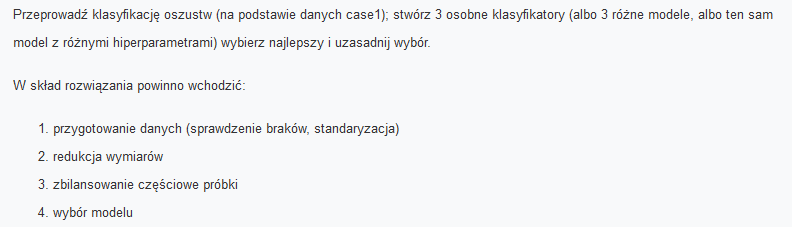

In [2]:
data = pd.read_csv('case1.csv', sep=';')

In [3]:
data.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

In [5]:
# Checking how many of each column contains values equal to 0
results = {}
perc_res = {}

for column in data.columns:
    if data[column].dtype == 'float64':
        count_nans = data[column].isna().sum()
        percentage_results = (count_nans / len(data)) * 100
        results[column] = count_nans
        perc_res[column] = percentage_results

        
'''
red - null cells above 90%
orange -  null cells between 80% and 90%
green -  null cells below 25%

'''

for column, zero_count in results.items():
    percentage = perc_res[column]
    if percentage > 90:
        color = Fore.RED  
    elif percentage > 80:
        color = Fore.YELLOW 
    elif percentage < 25:
        color = Fore.GREEN 
    else:
        color = ''  

    print(f'{color}Column {column} includes {percentage:.2f} % null cells.{Style.RESET_ALL}')

Column Avg min between sent tnx includes 0.00 % null cells.
Column Avg min between received tnx includes 0.00 % null cells.
Column Time Diff between first and last (Mins) includes 0.00 % null cells.
Column min value received includes 0.00 % null cells.
Column max value received  includes 0.00 % null cells.
Column avg val received includes 0.00 % null cells.
Column min val sent includes 0.00 % null cells.
Column max val sent includes 0.00 % null cells.
Column avg val sent includes 0.00 % null cells.
Column min value sent to contract includes 0.00 % null cells.
Column max val sent to contract includes 0.00 % null cells.
Column avg value sent to contract includes 0.00 % null cells.
Column total Ether sent includes 0.00 % null cells.
Column total ether received includes 0.00 % null cells.
Column total ether sent contracts includes 0.00 % null cells.
Column total ether balance includes 0.00 % null cells.
Column Total ERC20 tnxs includes 8.42 % null cells.
Column ERC20 total Ether received i

In [6]:
data.describe().round(3)

,Unnamed: 0,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,9841.000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000,9012.000
mean,4920.000,1815.050,0.221,5086.879,8004.851,218333.258,115.932,163.701,3.730,30.361,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.385,4.827
std,2840.996,1222.622,0.415,21486.550,23081.715,322937.926,757.226,940.837,141.446,298.621,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735,16.679
min,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,0.000
25%,2460.000,821.000,0.000,0.000,0.000,316.930,1.000,1.000,0.000,1.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,0.000
50%,4920.000,1641.000,0.000,17.340,509.770,46637.030,3.000,4.000,0.000,2.000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,1.000
75%,7380.000,2601.000,0.000,565.470,5480.390,304070.980,11.000,27.000,0.000,5.000,...,9.900000e+01,2.946500e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000,2.000
max,9840.000,4729.000,1.000,430287.670,482175.490,1954860.950,10000.000,10000.000,9995.000,9999.000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000,737.000


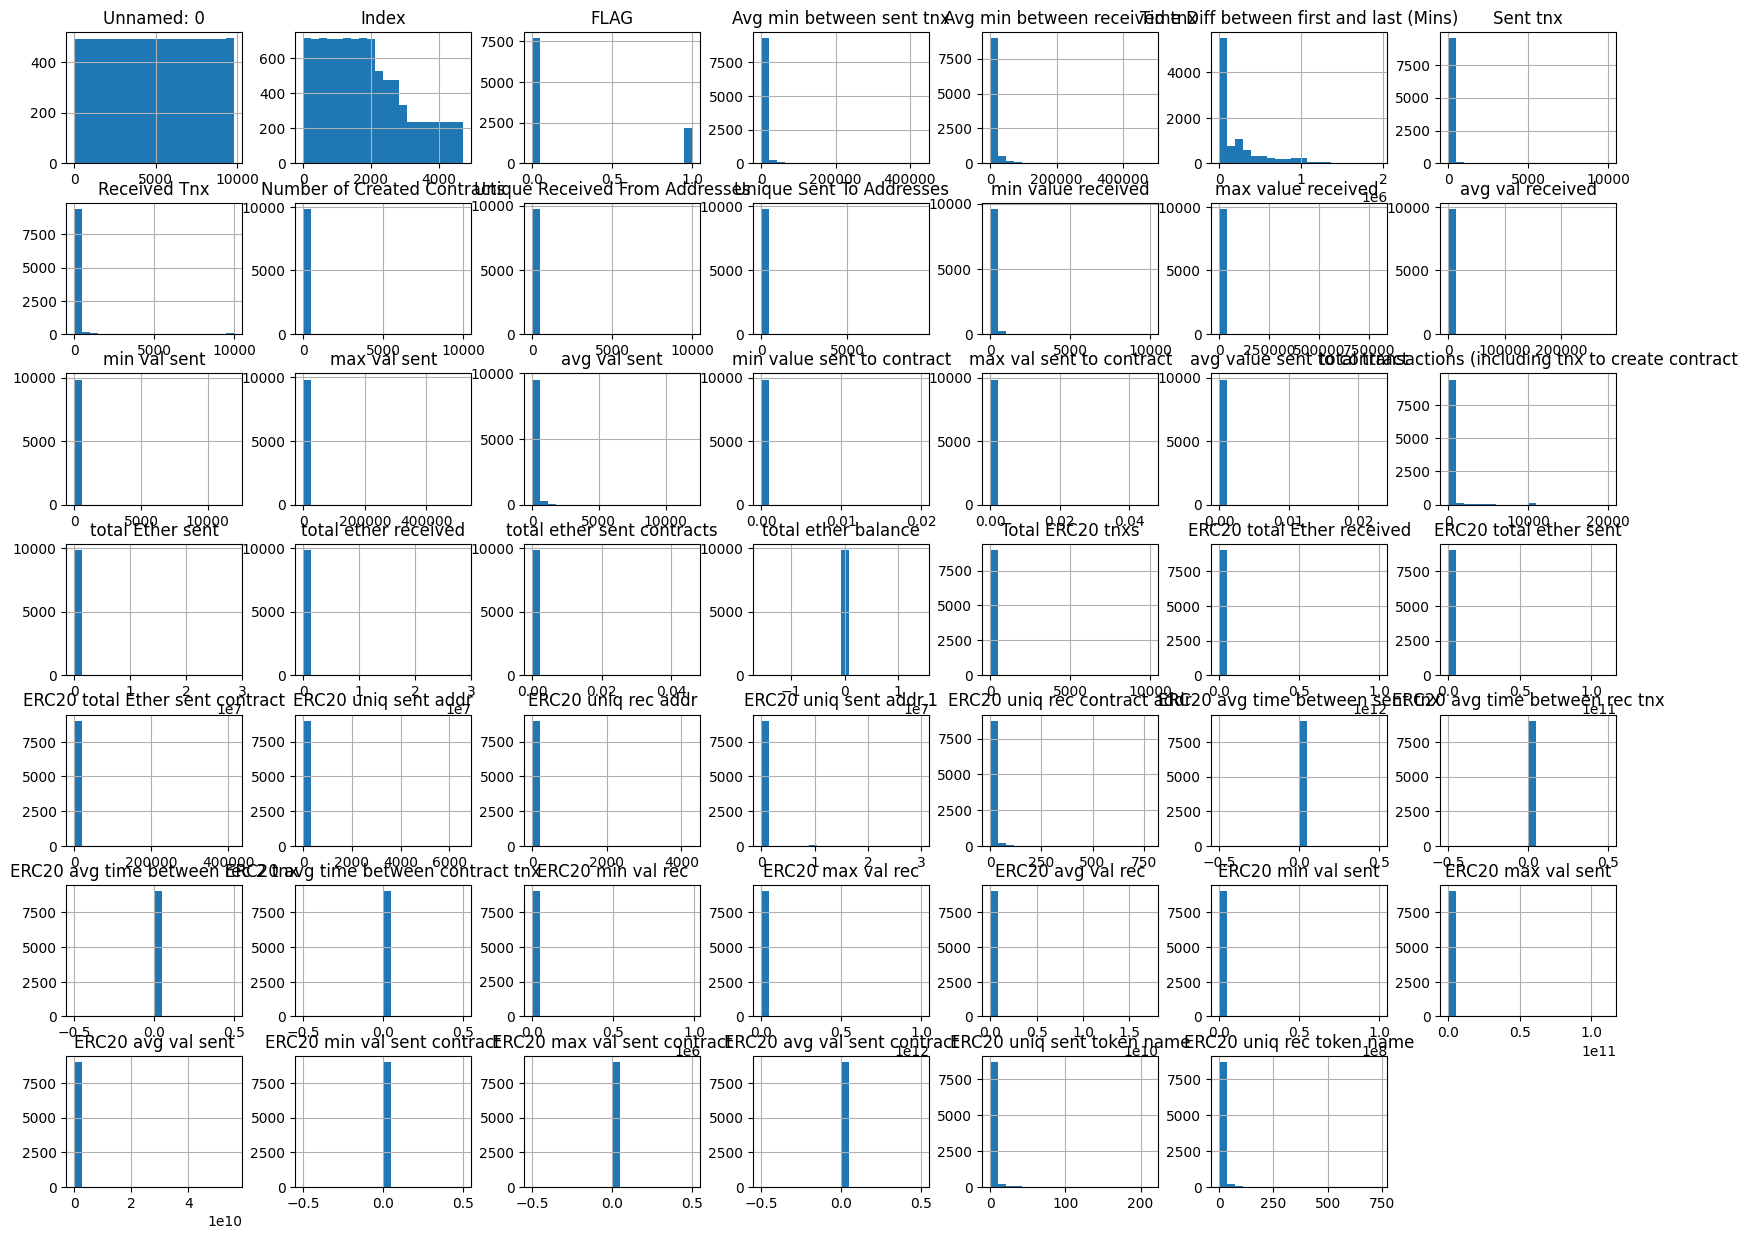

In [7]:
data.hist(bins = 20, figsize = (20, 15))
plt.show()

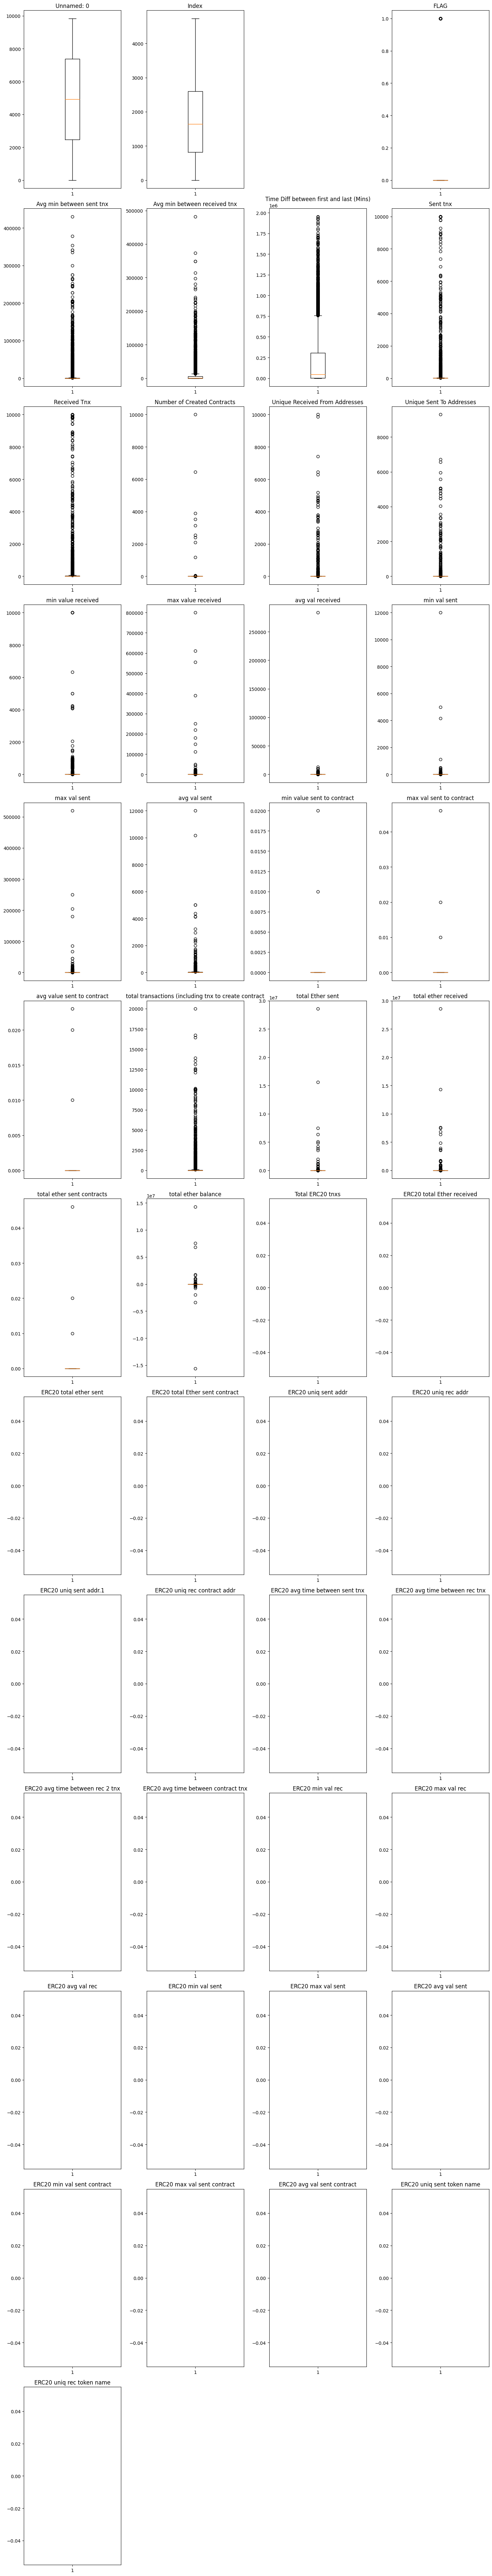

In [8]:
num_cols = 4
num_rows = (len(data.columns) + num_cols - 1) // num_cols

subplot_height = 6

# Oblicz wysokość całej figury
figure_height = subplot_height * num_rows

plt.figure(figsize=(15, figure_height))

for i, column in enumerate(data.columns):
    if pd.api.types.is_numeric_dtype(data[column]):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Wykres pudełkowy z zaznaczonymi wartościami odstającymi
        plt.boxplot(data[column], showfliers=True)
        
        plt.title(column)

plt.tight_layout()
plt.show()

## Przygotowanie danych

In [9]:
# data = pd.read_csv('case1.csv', sep=';')

In [10]:
df=data.drop(columns=['Index', 'Address' ], axis = 1)
df.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
df.head(1)

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.0,16830998.35,271779.92,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire


In [12]:
liczba_duplikatow = df['Index'].duplicated().sum()

print("Liczba duplikatów:", liczba_duplikatow)

Liczba duplikatów: 0


In [13]:
df.describe()

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,4920.000000,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,2840.996333,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,2460.000000,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,4920.000000,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,7380.000000,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,9840.000000,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [14]:
df.head()

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


### Uzupełnienie braków średnią

In [15]:
# uzupełnieinie braków średnią
numeric_columns = df.select_dtypes(include=['number'])

# wybór numerycznych kolumn
numeric_columns.fillna(numeric_columns.mean(), inplace=True)

# złączenie uzupełnionych kolumn z oryginalnymi danymi
df.update(numeric_columns)

In [16]:
df.describe()

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.841000e+03,9.841000e+03,9.841000e+03,9.841000e+03,9.841000e+03,9841.0,9841.0,9841.0,9841.000000,9841.000000
mean,4920.000000,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,2840.996333,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,...,1.008377e+10,2.049013e+08,1.008210e+06,1.129109e+09,5.660130e+08,0.0,0.0,0.0,6.445170,15.960582
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,2460.000000,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,4920.000000,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,...,5.356400e-01,4.332520e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,7380.000000,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,...,6.000000e+02,1.480957e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,4.000000
max,9840.000000,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [17]:
# Kolumna ERC20 most sent token i ERC20_most_rec_token_type nie są numeryczne
df['ERC20 most sent token type'].value_counts()

ERC20 most sent token type
0                                                         4399
                                                          1191
EOS                                                        138
OmiseGO                                                    137
Golem                                                      130
                                                          ... 
BlockchainPoland                                             1
Covalent Token                                               1
Nebula AI Token                                              1
Blocktix                                                     1
eosDAC Community Owned EOS Block Producer ERC20 Tokens       1
Name: count, Length: 304, dtype: int64

In [18]:
df['ERC20_most_rec_token_type'].value_counts()

ERC20_most_rec_token_type
0                        4399
OmiseGO                   873
Blockwell say NOTSAFU     779
DATAcoin                  358
Livepeer Token            207
                         ... 
BCDN                        1
Egretia                     1
UG Coin                     1
Yun Planet                  1
INS Promo1                  1
Name: count, Length: 466, dtype: int64

In [19]:
# Uzupełnienie wartości w kolumnach nienumerycznych
for column in ['ERC20 most sent token type', 'ERC20_most_rec_token_type']:
    if df[column].dtype == 'object':
        most_common_value = df[column].mode()[0]
        df[column].fillna(most_common_value, inplace=True)

In [20]:
df.head()

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,0,XENON
3,3,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


## Tworzenie modeli

### Podział zbioru

In [21]:
y = df['FLAG']
X = df.drop(['FLAG'], axis=1)

In [23]:
y.value_counts()

FLAG
0    7662
1    2179
Name: count, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Pipeline

In [27]:
y_train.value_counts()

FLAG
0    5135
1    1458
Name: count, dtype: int64

In [38]:
columns_to_encode = ['ERC20 most sent token type', 'ERC20_most_rec_token_type']

onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# przkształcenie nienumerycznych kolumn
column_transformer = ColumnTransformer([
    ('onehot', onehot_encoder, columns_to_encode)],  
    remainder='passthrough'
)


over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.5)
pca = PCA(n_components=0.95) 
minmax_scaler = MinMaxScaler()
# rfe = RFE(estimator=model_to_rfe, n_features_to_select=10)

# pipeline = make_pipeline(column_transformer, over, under, pca, model)


## KNN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2527
           1       0.99      0.97      0.98       721

    accuracy                           0.99      3248
   macro avg       0.99      0.98      0.99      3248
weighted avg       0.99      0.99      0.99      3248

ROC-AUC Score: 0.9837540965341305


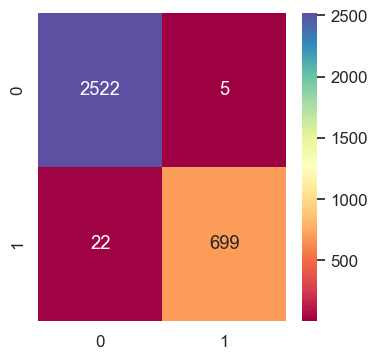

Accuracy: 0.9917
Precision: 0.9929
Recall: 0.9695


In [40]:
model_knn = KNeighborsClassifier(n_neighbors=4)
knn_pipeline = make_pipeline(column_transformer, minmax_scaler, over, under, pca, model_knn)
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(knn_pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=1)

print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

cm_knn = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_knn,  cmap = 'Spectral',  annot=True, fmt='d')
plt.show()

accuracy = round(accuracy_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred),4)
recall = round(recall_score(y_test, y_pred),4)

print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')

## RandomForest 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2527
           1       0.99      0.97      0.98       721

    accuracy                           0.99      3248
   macro avg       0.99      0.98      0.99      3248
weighted avg       0.99      0.99      0.99      3248

ROC-AUC Score: 0.9889042995839112


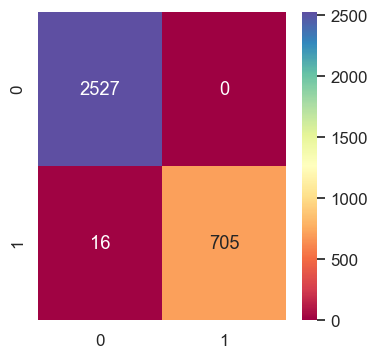

Accuracy: 0.9951
Precision: 1.0
Recall: 0.9778


In [41]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_pipeline = make_pipeline(column_transformer, minmax_scaler, over, under, pca, rf_model)
rf_pipeline.fit(X_train, y_train)
rf_y_pred = rf_pipeline.predict(X_test)
rf_scores = cross_val_score(rf_pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=1)

print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, rf_y_pred))

cm_rf = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_rf,  cmap = 'Spectral',  annot=True, fmt='d')
plt.show()

accuracy = round(accuracy_score(y_test, rf_y_pred), 4)
precision = round(precision_score(y_test, rf_y_pred),4)
recall = round(recall_score(y_test, rf_y_pred),4)

print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')

## LogisticRegression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2527
           1       0.99      0.99      0.99       721

    accuracy                           1.00      3248
   macro avg       1.00      0.99      0.99      3248
weighted avg       1.00      1.00      1.00      3248

ROC-AUC Score: 0.9941563156742136


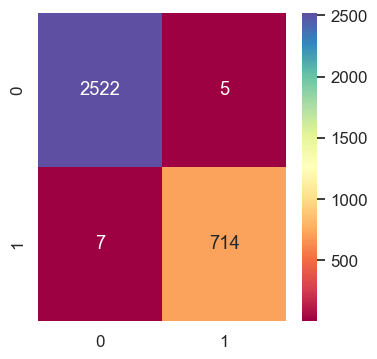

Accuracy: 0.9963
Precision: 0.993
Recall: 0.9903


In [42]:
log_model = LogisticRegression(solver='liblinear', random_state=1)
log_pipeline = make_pipeline(column_transformer, minmax_scaler, over, under, pca, log_model)
log_pipeline.fit(X_train, y_train)
log_y_pred = log_pipeline.predict(X_test)
log_scores = cross_val_score(log_pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=1)

print(classification_report(y_test, log_y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, log_y_pred))


cm_lr = confusion_matrix(y_test, log_y_pred)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_lr,  cmap = 'Spectral',  annot=True, fmt='d')
plt.show()

accuracy = round(accuracy_score(y_test, log_y_pred), 4)
precision = round(precision_score(y_test, log_y_pred),4)
recall = round(recall_score(y_test, log_y_pred),4)

print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')

## SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2527
           1       1.00      0.99      1.00       721

    accuracy                           1.00      3248
   macro avg       1.00      1.00      1.00      3248
weighted avg       1.00      1.00      1.00      3248

ROC-AUC Score: 0.9968303487384789


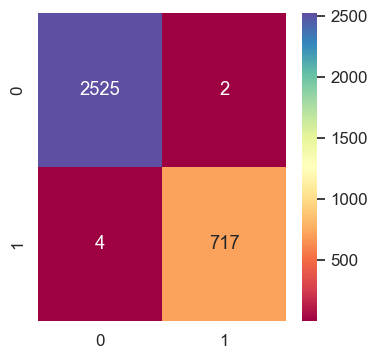

Accuracy: 0.9982
Precision: 0.9972
Recall: 0.9945


In [43]:
svm_model = SVC(kernel='linear', random_state=1)  
svm_pipeline = make_pipeline(column_transformer, minmax_scaler, over, under, pca, svm_model)

svm_pipeline.fit(X_train, y_train)

svm_y_pred = svm_pipeline.predict(X_test)

svm_scores = cross_val_score(svm_pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=1)

print(classification_report(y_test, svm_y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, svm_y_pred))

cm_svm = confusion_matrix(y_test, svm_y_pred)
plt.figure(figsize=(4, 4))
sns.set(font_scale=1.1)
sns.heatmap(cm_svm, cmap='Spectral', annot=True, fmt='d')
plt.show()

accuracy_svm = round(accuracy_score(y_test, svm_y_pred), 4)
precision_svm = round(precision_score(y_test, svm_y_pred), 4)
recall_svm = round(recall_score(y_test, svm_y_pred), 4)

print(f'Accuracy: {accuracy_svm}\nPrecision: {precision_svm}\nRecall: {recall_svm}')

In [48]:
print(f"KNN scores:\n {scores.mean()}")
print(f"RF scores:\n {rf_scores.mean()}")
print(f"Log scores:\n {log_scores.mean()}")
print(f"SVM scores:\n {svm_scores.mean()}")


KNN scores:
 0.9954627226788632
RF scores:
 0.9999783437623706
Log scores:
 0.9997540774611935
SVM scores:
 0.9996996091537317


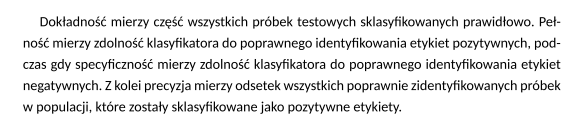
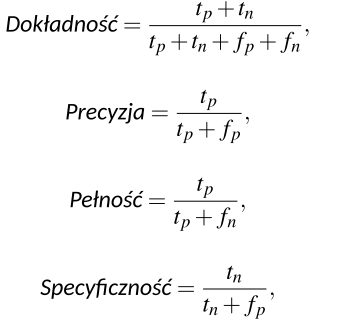

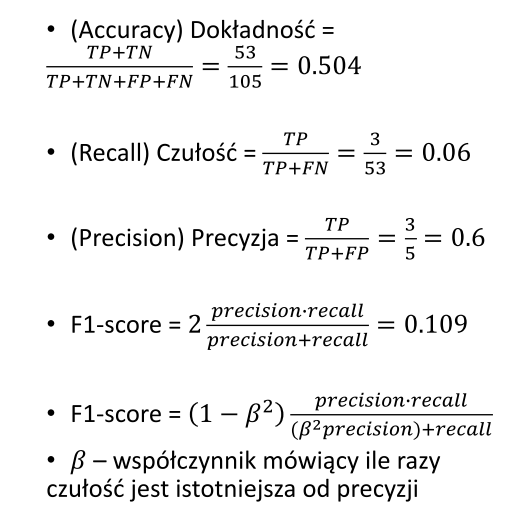

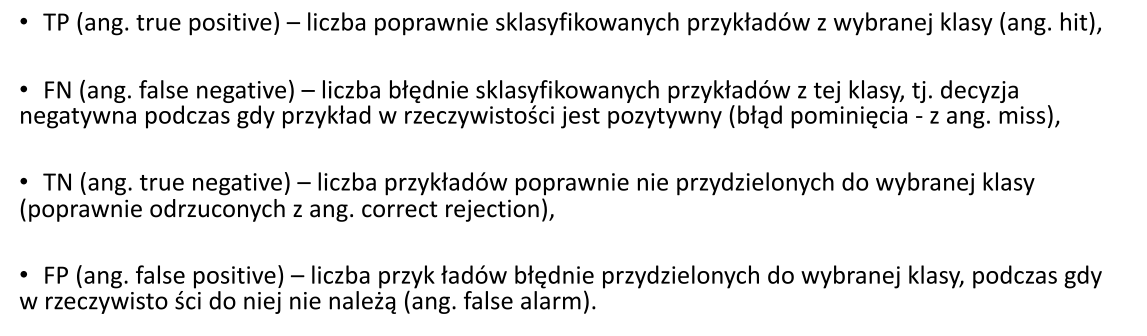

## Hiperparametryzacja
